# Machine Learning on a Public Dataset

Train and Evaluate the machine learning models

## Importing the required libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
# local modules
from src.data_pipeline import BrainDataset
from src.losses import FocalDiceLoss
from src.models import UNet
from src.utils import train_one_epoch, evaluate, export2onnx

## Visualizing CossineAnnealing learning rate scheduler

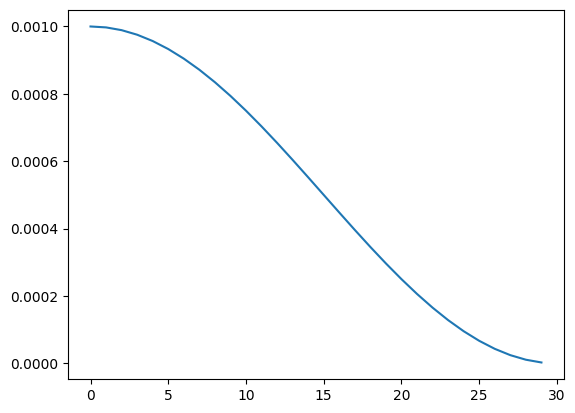

In [2]:
dummy_model = torch.nn.Sequential(torch.nn.Linear(32, 32))
dummy_opt = torch.optim.RAdam(dummy_model.parameters())
dummy_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(dummy_opt, T_max=30)

lrs = []
for ep in range(30):
    lrs.append(dummy_scheduler.get_last_lr())
    dummy_opt.step()
    dummy_scheduler.step()

plt.plot(lrs)
plt.show()

## Building the data pipeline

In [3]:
class RescaleMask:
    def __call__(self, img: torch.Tensor):
        assert img.min() >=0 and img.max() <= 1
        return img.clamp(min=0, max=1)


mask_transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleMask()
])

train_loader = BrainDataset(True, transforms.ToTensor(), mask_transform)
train_loader = DataLoader(train_loader, batch_size=64, shuffle=True)
test_loader = BrainDataset(False, transforms.ToTensor(), mask_transform)
test_loader = DataLoader(test_loader, batch_size=64, shuffle=False)

## Building and Training U-Net

In [4]:
unet_model = UNet(in_channels=3)
loss = FocalDiceLoss()
# optimizer = torch.optim.SGD(unet_model.parameters(), lr=1e-3, momentum=.9, nesterov=True)
optimizer = torch.optim.RAdam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

min_test_loss = 1e10
early_stopping_counter, patience = 0, 4
writer = SummaryWriter() # logs evaluation metrics
# train and evaluate
for epoch in range(30):
    print(f'--------- Epoch {epoch + 1} ---------')
    print(f'Current learning rate: {scheduler.get_last_lr()[0]:.5f}')
    # train for one epoch
    train_loss = train_one_epoch(unet_model, loss, optimizer, train_loader)
    scheduler.step()
    writer.add_scalar('Loss/Train', train_loss, epoch)
    # evaluate the model
    (test_loss, test_miou, test_precision, test_sensitivity, test_f1) = evaluate(unet_model, loss, test_loader)
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('mIoU/Test', test_miou, epoch)
    writer.add_scalar('Precision/Test', test_precision, epoch)
    writer.add_scalar('Sensitivity/Test', test_sensitivity, epoch)
    writer.add_scalar("F1 Score/Test", test_f1, epoch)
    # save the best model
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        early_stopping_counter = 0
        torch.save(unet_model, 'models/model.pth')
    else:
        early_stopping_counter += 1
        # early stopping
        if early_stopping_counter > patience:
            break

--------- Epoch 1 ---------
Current learning rate: 0.00100


51it [00:26,  1.95it/s]


[Train]  Loss: 1.0900
[Test]  Loss: 1.0303 mIoU: 0.0775 Precision: 0.1073 Recall: 0.7315 F1: 0.1024
--------- Epoch 2 ---------
Current learning rate: 0.00100


51it [00:24,  2.07it/s]


[Train]  Loss: 1.0163
[Test]  Loss: 1.0074 mIoU: 0.3840 Precision: 0.4765 Recall: 0.8076 F1: 0.4248
--------- Epoch 3 ---------
Current learning rate: 0.00099


51it [00:24,  2.10it/s]


[Train]  Loss: 0.9970
[Test]  Loss: 0.9789 mIoU: 0.6664 Precision: 0.8725 Recall: 0.7875 F1: 0.6942
--------- Epoch 4 ---------
Current learning rate: 0.00098


51it [00:24,  2.06it/s]


[Train]  Loss: 0.9823
[Test]  Loss: 0.9742 mIoU: 0.6352 Precision: 0.8270 Recall: 0.7998 F1: 0.6643
--------- Epoch 5 ---------
Current learning rate: 0.00096


51it [00:24,  2.07it/s]


[Train]  Loss: 0.9673
[Test]  Loss: 0.9572 mIoU: 0.7031 Precision: 0.8794 Recall: 0.8131 F1: 0.7333
--------- Epoch 6 ---------
Current learning rate: 0.00093


51it [00:24,  2.05it/s]


[Train]  Loss: 0.9534
[Test]  Loss: 0.9615 mIoU: 0.6824 Precision: 0.9365 Recall: 0.7367 F1: 0.7034
--------- Epoch 7 ---------
Current learning rate: 0.00090


51it [00:24,  2.04it/s]


[Train]  Loss: 0.9568
[Test]  Loss: 0.9432 mIoU: 0.7151 Precision: 0.9211 Recall: 0.7868 F1: 0.7404
--------- Epoch 8 ---------
Current learning rate: 0.00087


51it [00:24,  2.06it/s]


[Train]  Loss: 0.9186
[Test]  Loss: 0.9213 mIoU: 0.6048 Precision: 0.7377 Recall: 0.8514 F1: 0.6439
--------- Epoch 9 ---------
Current learning rate: 0.00083


51it [00:24,  2.05it/s]


[Train]  Loss: 0.8796
[Test]  Loss: 0.9061 mIoU: 0.6110 Precision: 0.7483 Recall: 0.8552 F1: 0.6469
--------- Epoch 10 ---------
Current learning rate: 0.00079


51it [00:24,  2.07it/s]


[Train]  Loss: 0.8292
[Test]  Loss: 0.8901 mIoU: 0.7370 Precision: 0.9866 Recall: 0.7465 F1: 0.7573
--------- Epoch 11 ---------
Current learning rate: 0.00075


51it [00:24,  2.09it/s]


[Train]  Loss: 0.7233
[Test]  Loss: 0.8028 mIoU: 0.7527 Precision: 0.9474 Recall: 0.7980 F1: 0.7794
--------- Epoch 12 ---------
Current learning rate: 0.00070


51it [00:24,  2.11it/s]


[Train]  Loss: 0.5696
[Test]  Loss: 0.8283 mIoU: 0.3905 Precision: 0.4704 Recall: 0.8499 F1: 0.4309
--------- Epoch 13 ---------
Current learning rate: 0.00065


51it [00:24,  2.12it/s]


[Train]  Loss: 0.4476
[Test]  Loss: 0.6367 mIoU: 0.7374 Precision: 0.8914 Recall: 0.8343 F1: 0.7681
--------- Epoch 14 ---------
Current learning rate: 0.00060


51it [00:24,  2.11it/s]


[Train]  Loss: 0.3220
[Test]  Loss: 0.6176 mIoU: 0.7718 Precision: 0.9679 Recall: 0.7932 F1: 0.7938
--------- Epoch 15 ---------
Current learning rate: 0.00055


51it [00:24,  2.09it/s]


[Train]  Loss: 0.2501
[Test]  Loss: 0.4752 mIoU: 0.7889 Precision: 0.9235 Recall: 0.8551 F1: 0.8228
--------- Epoch 16 ---------
Current learning rate: 0.00050


51it [00:24,  2.10it/s]


[Train]  Loss: 0.2254
[Test]  Loss: 0.5178 mIoU: 0.7518 Precision: 0.8908 Recall: 0.8497 F1: 0.7852
--------- Epoch 17 ---------
Current learning rate: 0.00045


51it [00:24,  2.11it/s]


[Train]  Loss: 0.2037
[Test]  Loss: 0.5854 mIoU: 0.7737 Precision: 0.9782 Recall: 0.7890 F1: 0.8004
--------- Epoch 18 ---------
Current learning rate: 0.00040


51it [00:24,  2.10it/s]


[Train]  Loss: 0.2053
[Test]  Loss: 0.5300 mIoU: 0.7604 Precision: 0.9220 Recall: 0.8285 F1: 0.7888
--------- Epoch 19 ---------
Current learning rate: 0.00035


51it [00:24,  2.04it/s]


[Train]  Loss: 0.1869
[Test]  Loss: 0.5242 mIoU: 0.7840 Precision: 0.9683 Recall: 0.8068 F1: 0.8091
--------- Epoch 20 ---------
Current learning rate: 0.00030


51it [00:24,  2.06it/s]


[Train]  Loss: 0.1600
[Test]  Loss: 0.5471 mIoU: 0.7787 Precision: 0.9816 Recall: 0.7922 F1: 0.8018


## Visual validation of UNet model

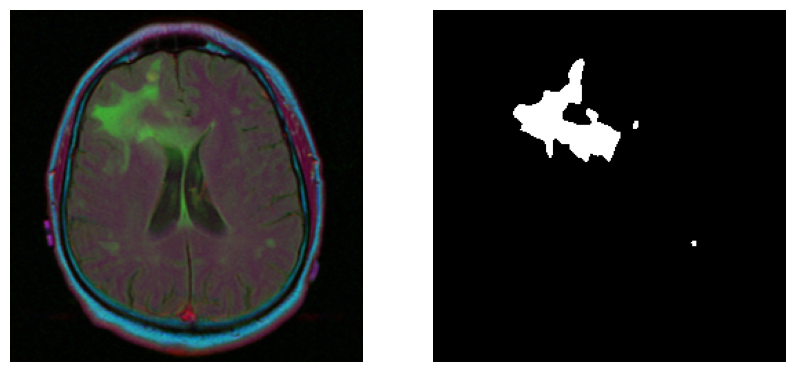

In [5]:
img = cv2.imread('dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif')
transform = transforms.ToTensor()
img = transform(img)
img = img.unsqueeze(0)
assert img.shape == (1, 3, 256, 256)
model = torch.load('models/model.pth')
model.eval()
device = torch.device('cuda')
pred = (model(img.to(device)) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0)
assert pred.shape == (1, 256, 256)
pred = pred.squeeze()
assert pred.shape == (256, 256)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
assert pred.min() >= 0 and pred.max() <= 1
img = cv2.imread('dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif')
ax1.imshow(img)
ax1.axis('off')
ax2.imshow(pred, cmap='gray')
ax2.axis('off')
plt.show()

# Exporting the trained models to ONNX

In [6]:
export2onnx(
    model=model,
    model_name='models/unet.onnx',
    input_shape=(1, 3, 256, 256)
)